In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# Transforms an RGB matrix of pixels to a Grayscale matrix of pixels
#[CITE] https://stackoverflow.com/q/12201577
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray/256

# Convert a array of lists to a singular list
#[CITE] https://stackoverflow.com/a/716482
def listsToList(listOfLists):
    return list(itertools.chain.from_iterable(listOfLists))

# Converts a image to a grayscale singular array of pixels
maxSize=(128,128)
def imageToArray(img):
    return listsToList(rgb2gray(np.asarray(img)))


In [3]:
%%time
data = {'Id': [], 'ImageData': [], 'ImageSize': [], 'ImageClass': []}
maxSize = (128,128)

for i in range(0,2000):
    img = Image.open(f'./train/cat.{i}.jpg')
    smallImage = img.resize(maxSize, Image.ANTIALIAS)
    
    data['Id'].append(f'cat_{i}')
    data['ImageData'].append(imageToArray(smallImage))
    data['ImageSize'].append(maxSize)
    data['ImageClass'].append(0)
    
    img = Image.open(f'./train/dog.{i}.jpg')
    smallImage = img.resize(maxSize, Image.ANTIALIAS)
    
    data['Id'].append(f'dog_{i}')
    data['ImageData'].append(imageToArray(smallImage))
    data['ImageSize'].append(maxSize)
    data['ImageClass'].append(1)

ds = pd.DataFrame(data=data)

CPU times: user 41.2 s, sys: 1.62 s, total: 42.8 s
Wall time: 45 s


In [4]:
ds.head()

,Id,ImageClass,ImageData,ImageSize
0,cat_0,0,"[0.65571328125, 0.675242578125, 0.6791484375, ...","(128, 128)"
1,dog_0,1,"[0.456852734375, 0.419130078125, 0.47682734375...","(128, 128)"
2,cat_1,0,"[0.16814453125, 0.171538671875, 0.162769921875...","(128, 128)"
3,dog_1,1,"[0.6715203125, 0.459443359375, 0.523977734375,...","(128, 128)"
4,cat_2,0,"[0.221508984375, 0.15321953125, 0.163492578125...","(128, 128)"


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
Id            4000 non-null object
ImageClass    4000 non-null int64
ImageData     4000 non-null object
ImageSize     4000 non-null object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [6]:
from sklearn.decomposition import PCA

#[CITE] Eric Larson - 04. Dimension Reduction and Images Notebook

# Convert the series to a matrix 4000x16384
X = np.asarray(ds['ImageData'].tolist())

numComp = 1000
pca = PCA(n_components=numComp)
%time pca.fit(X)

CPU times: user 1min 2s, sys: 1.88 s, total: 1min 3s
Wall time: 20 s


PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
# Use 128x128 because that is the the maxSize defined above
eigenfaces = pca.components_.reshape((numComp, 128, 128))

In [8]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

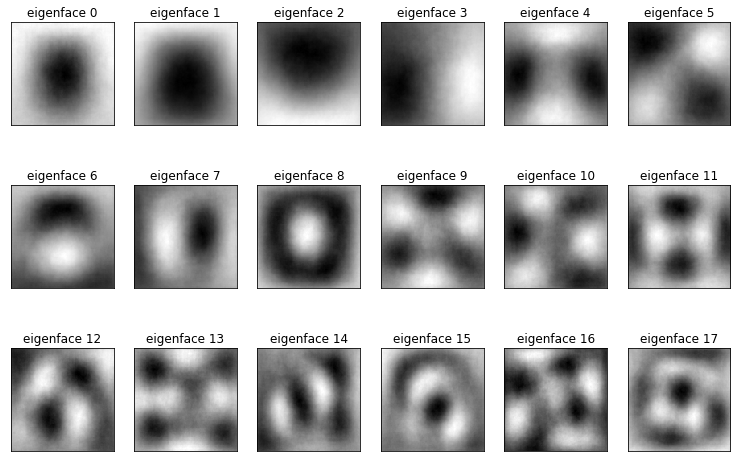

In [9]:
%matplotlib inline
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 128, 128)

In [12]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1500    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

/Users/jake.rowland/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


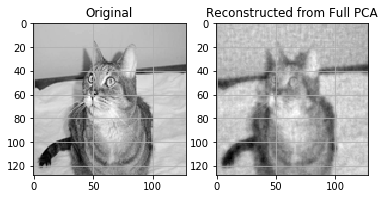

In [13]:
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape(maxSize), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape(maxSize), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()

# END CITATION